In [2]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import warnings

# Sec 00: Outline

1. Kernel review
2. Drawing samples from a GP prior, varying hyperparameters
3. First GP, and the two tricks we'll need
4. First trick and the Cholesky decomposition
5. The second trick, non-centered parameterization
6. From multivariate normals to GPs
7. Summary

# Sec 10: Kernel Review

At this point in time, it's enough to think of setting a GP prior as 

1. Set values for the kernel hyperparameters
2. Plug the x values of the data into the kernel function to calculate the kernel
3. Use the kernel as the covariance matrix of a multivariate normal distribution

While this view is enough to start fitting basic GPs, we'll see that this is far from the full story, but at this point in time this understanding is enough to start building some intuition and modeling skills. 

We'll start by drawing some samples from a GP prior.  Let's define our domain $x = 1$ to $x = 10$, over 100 points that are evenly spaced.  Then, we'll set the lengthscale `ell` and introduce a new parameter `eta`, which is used to scale the overall height or variance of our GP prior.  In this section we'll follow the three steps above and see how to draw samples from the GP prior.  We'll plot the results in a few different ways to gain a more understanding of what GPs can be used to represent. 

In [403]:
# Define the domain
N = 100
x = np.linspace(0, 10, N)

# Copy/paste our kernel function from the art class lesson
def kernel(x, x_prime, eta, ell):
    return np.square(eta) * np.exp( -0.5 * np.square(x - x_prime) / np.square(ell))

# Calculate kernel/covariance matrix values for every possible pair of x values in the data
K = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        K[i, j] = kernel(x[i], x[j], eta=1.0, ell=2.0)

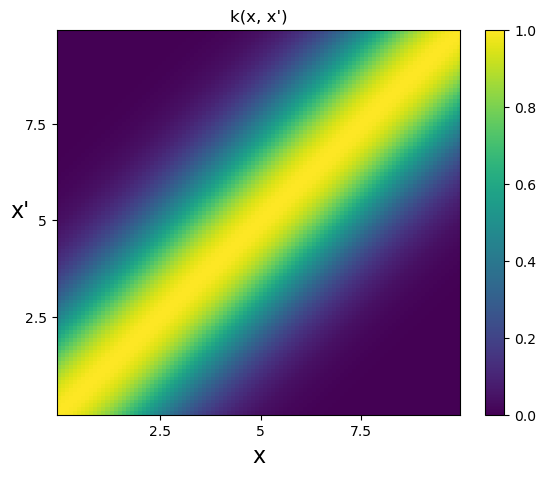

In [404]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5));

m = ax.imshow(K, origin="lower", interpolation='none', aspect='auto', vmin=0, vmax=1); 
plt.colorbar(m);

ax.set_xticks([ 25, 50, 75 ]);
ax.set_yticks([ 25, 50, 75 ]);
ax.set_xticklabels([2.5, 5, 7.5])
ax.set_yticklabels([2.5, 5, 7.5])
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("x'", rotation=0, fontsize=16)
ax.set_title("k(x, x')");

PyMC (and probably every other GP software library) already has this kernel function built in.  It's called the Exponentiated Quadratic, and the call in PyMC is `pm.gp.cov.ExpQuad`.  You may also see it called `RBF` for "radial basis function".  From here on out, we'll use the built in PyMC function instead of our home made numpy version.  We can verify they produce the same result:  

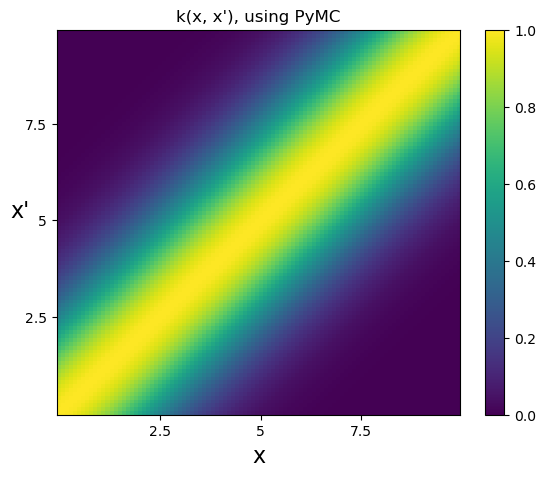

In [405]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5));

eta = 1.0
ell = 2.0

# construct PyMC covariance function
cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)

# evaluate the covariance function over the domain `x`
K = cov_func(x[:, None]).eval()

m = ax.imshow(K, origin="lower", interpolation='none', aspect='auto', vmin=0, vmax=1); 
plt.colorbar(m);

ax.set_xticks([ 25, 50, 75 ]);
ax.set_yticks([ 25, 50, 75 ]);
ax.set_xticklabels([2.5, 5, 7.5])
ax.set_yticklabels([2.5, 5, 7.5])
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("x'", rotation=0, fontsize=16)
ax.set_title("k(x, x'), using PyMC");

There are a couple details to note here about how PyMC covariance functions work.  The PyMC documentation (link here) has more information.

1. The `input_dim` parameter gives the dimension of the input domain.  This (and all previous examples we've seen) the input is in one dimensional.  Later we'll see examples of higher dimensional inputs.
2. The `input_dim` must be the same as the number of columns of the input, in this case `x`.  That's why we write `x[:, None]` instead of just `x`.

In [406]:
x.shape, x[:, None].shape

((100,), (100, 1))

`x` as we defined it is a length 100 vector, and `x[:, None]` is a matrix with 100 rows and one column, where that one column corresponds to `input_dim = 1`.  Again, the `input_dim` *must* match the number of columns of the input.  Reasons for this design will be more apparent when we start building more elaborate covariance functions.     

# Sec 20: Drawing samples from a GP prior

Now that we've calculated the kernel, let's plug it into a multivariate normal distribution and draw one sample.  $n$ pretty much always denotes the number of data points.  For GPs, there is some ambiguity that's good to address up front.  Our domain is *100 points* between $x=0$ and $x = 100$. If we draw *one sample*, $n$ can either be 100, or one, depending on context.  

Let's do that, we'll first set the hyperparameters `eta` and `ell` and define the covariance function, then calculate the covariance matrix, and finally use it to draw one sample from a multivariate normal.  

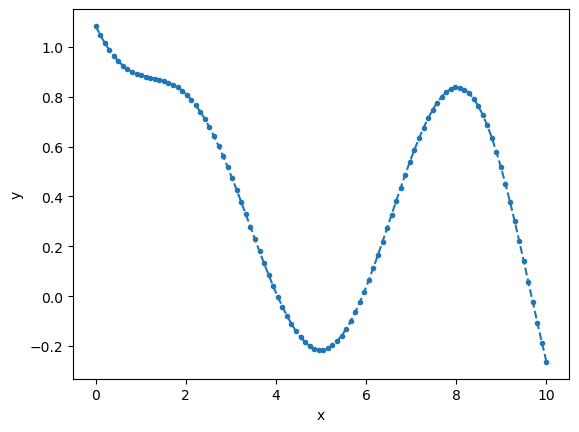

In [407]:
eta = 1.0
ell = 2.0

# construct PyMC covariance function
cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)

# evaluate the covariance function over the domain `x`
K = cov_func(x[:, None]).eval()

# zero mean
mu = np.zeros(N)

# build PyMC distribution
mv_normal = pm.MvNormal.dist(mu=mu, cov=K)

# use pm.draw to draw some samples
n_samples = 1
samples1 = pm.draw(mv_normal, n_samples).T
plt.plot(x, samples1, "--.");
plt.xlabel("x"); plt.ylabel("y");

It's important to emphasize here that this curve is a single sample from our GP prior over the domain of interest, $x=0$ to $x=10$.  Thinking about representing data, this could be a single time series.  There may be 100 dots, but this is visits to **one** website over 10 days, or temperature changes at **a single** weather station over 10 minutes.  

## Drawing samples from a GP, what does `ell` do? (review)

Let's remind ourselves what the lengthscale is doing. 

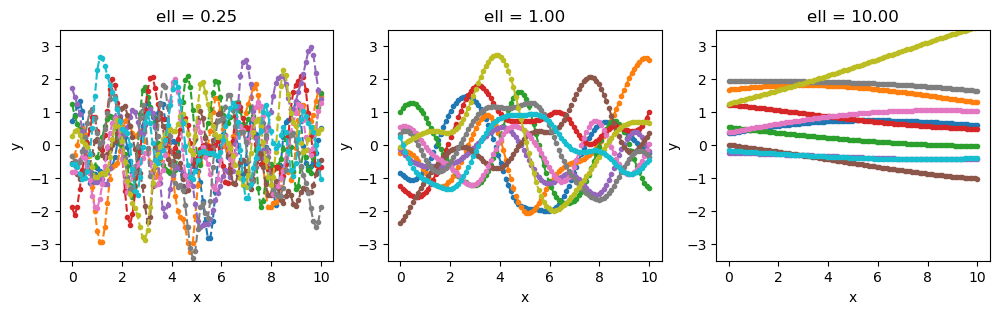

In [408]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs = axs.flatten()

for i, ell in enumerate([0.25, 1.0, 10.0]):
    # keep the same scale
    eta = 1.0

    # construct PyMC covariance function
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)

    # evaluate the covariance function over the domain `x`
    K = cov_func(x[:, None]).eval()

    # zero mean
    mu = np.zeros(N)

    # build PyMC distribution
    mv_normal = pm.MvNormal.dist(mu=mu, cov=K)

    # use pm.draw to draw some samples
    n_samples = 10
    samples = pm.draw(mv_normal, n_samples).T
    axs[i].plot(x, samples, "--.");
    axs[i].set_xlabel("x"); axs[i].set_ylabel("y");
    axs[i].set_ylim([-3.5, 3.5]);
    axs[i].set_title(f"ell = {ell:.2f}");

When the lengthscale is small, the GP samples look very noisy.  The $x$ values that are far apart, further than about 0.25, have very little relation to each other.  Then when the lengthscale is large, the samples are smooth and straight, nearly straight lines though you can see some slight bends.

## Drawing samples from a GP, what does `eta` do?

What about `eta`, the new parameter?  We can see in our plots from the prior that most of the points from the GP land between about $y=-2$ to $y=2$.  For a GP with the `ExpQuad` kernel, it's extremely unlikely for these sample paths to keep rising and rising way outside $y=-2$ to $y=2$.  

Let's try three different values of `eta`, 0.5, 1, and 2, and see what that does to samples from the prior.  Unlike the lengthscale, this parameter goes by a few different names, depending on the author of whatever you're reading.  You may see "scale" or "amplitude", or perhaps the `eta**2` is the variance of the GP.  We'll generally try to stick with "scale".  

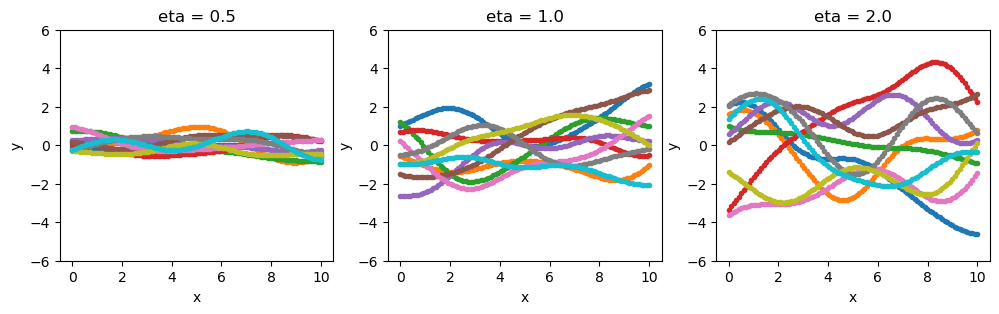

In [356]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs = axs.flatten()

for i, eta in enumerate([0.5, 1.0, 2.0]):
    # keep the same lengthscale
    ell = 2.0

    # construct PyMC covariance function
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)

    # evaluate the covariance function over the domain `x`
    K = cov_func(x[:, None]).eval()

    # zero mean
    mu = np.zeros(N)

    # build PyMC distribution
    mv_normal = pm.MvNormal.dist(mu=mu, cov=K)

    # use pm.draw to draw some samples
    n_samples = 10
    samples = pm.draw(mv_normal, n_samples).T
    axs[i].plot(x, samples, "--.");
    axs[i].set_xlabel("x"); axs[i].set_ylabel("y");
    axs[i].set_ylim([-6, 6]);
    axs[i].set_title(f"eta = {eta:.1f}");

`eta` is analogous to the standard deviation on a normal distribution.  We can see that this is true if we take our GP samples and slide all the datapoints into one bucket.  What do I mean exactly?  Let's draw many samples from this GP prior, and then flatten them into a single vector, then put them all together into a histogram. 

In [357]:
eta = 1.0
ell = 2.0
cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)

# drawing this many samples takes a little time
n_samples = 10000
samples = pm.draw(mv_normal, n_samples).T

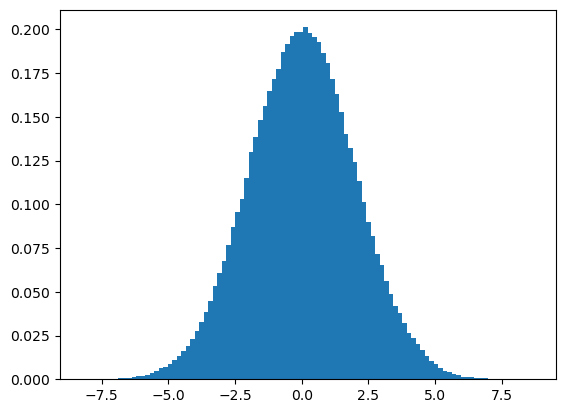

In [358]:
plt.hist(samples.flatten(), 100, density=True);

Now, let's take our 10k GP draws and plot uncertainty intervals around them.  This is shown in the plot below in the left panel for $1\sigma$, $2\sigma$, and $3\sigma$ levels.  The right plot is the same histogram is above, with these same intervals highlighted.  We've reproduced the plot in [this wikipedia article](https://en.wikipedia.org/wiki/Standard_deviation).

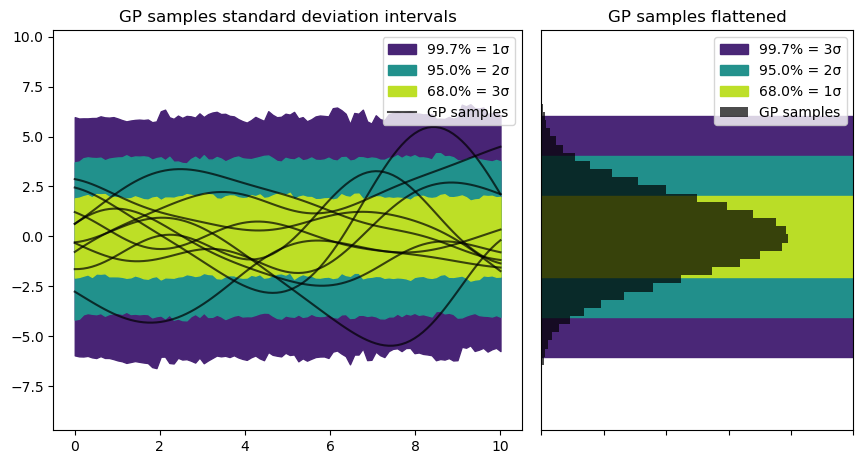

In [13]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(
    1, 2,  
    width_ratios=(3, 2),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0.05
)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax)
ax2.set_yticklabels([]);
ax2.set_xticklabels([]);

### plot left panel
# plot densities of the 5000 GP samples
hdi_probs = [0.68, 0.95, 0.997]
colors = [plt.cm.viridis(c) for c in [0.1, 0.5, 0.9]]
for i, hdi_prob in enumerate(hdi_probs[::-1]):
    
    with warnings.catch_warnings(): # suppress future warning
        warnings.filterwarnings("ignore", category=FutureWarning)
        interval = az.hdi(samples.T, hdi_prob=hdi_prob)
    
    lower, upper = interval[:, 0], interval[:, 1]
    ax1.fill_between(x, lower, upper, color=colors[i], label=f"{100*hdi_prob:.1f}% = {i+1}σ")
smin, smax = np.min(samples), np.max(samples)
    
ax1.set_ylim([smin, smax])

# plot the original samples from the plot above
ax1.plot(x, samples[:, 1:10], color="k", alpha=0.7);
ax1.plot(x, samples[:, 0], color="k", alpha=0.7, label="GP samples"); # just one so the legend looks right


### plot right panel
## first plot GP samples flattened out
s = samples.flatten()
for i in range(3)[::-1]:
    b = (i + 1) * np.std(s)
    hdi = hdi_probs[i]
    plt.fill_between([0, 0.5], [-b, -b], [b, b], color=colors[::-1][i], label=f"{100*hdi:.1f}% = {i+1}σ", alpha=0.99)
ax2.set_ylim([smin, smax]);

## then overlay normal pdf, with sigma = eta
ax2.hist(s, bins=np.linspace(smin, smax, 50), orientation="horizontal", density=True, color="k", alpha=0.7, label="GP samples");
ax2.set_xlim([0, 0.25])

ax1.legend(loc="upper right");
ax2.legend(loc="upper right");

ax1.set_title("GP samples standard deviation intervals")
ax2.set_title("GP samples flattened");

Even though the paths of the GPs follow nice smooth curves, they still follow Gaussian distributions along `y`.  These functions are definitely still Gaussian at their core.  

# Sec 30: Setting up our first GP

There are **two tricks** that are critical to using GPs in practice.  We call these things tricks because they aren't inherent to what a GP _is_, but you need to know them in order to use GPs in practice.  The first trick is required to fit even the most basic GP model.  We'll introduce it first.  After we implement the first trick we'll see that while the sampler runs, it doesn't do a good job.  It takes a very long time and it returns lots of warnings.  We'll need the second trick to make it sample nicely.  

In this section we'll set up our first model and learn the two tricks.  We'll consider the hyperparameters `eta` and `ell` fixed or known for now, and focus on inferring the posterior of the GP itself.  We'll use simulated data so we can verify that the results we get match the true data generating process.  Even though the data is simulated, we'll couch it in a somewhat realistic scenario so you can connect it to the real world.

### Data description

You work at a hospital and you have data on the number of times all the patients in a wing push their nurse call buttons for every hour.  You hope to model this data because it could help inform how many nurses need available and how to plan shifts.  If you have one weeks worth of hourly data, that's $24 \cdot 7 = 168$ data points total, and each of those data points is a count (e.g. there were 6 calls between 8am and 9am).  Although you observe counts, you know the underlying rate doesn't necessarily need to be an integer.  For instance, if you had a lot of data, say a months worth, you can imagine calculating an average of exactly 7.63172 calls per hour, or something like that (the average doesn't have to be an integer, of course).  But, you also hypothesize that this rate changes over time.  While the average over one month may be 7.63172, the rate may decrease at night but then peak first thing in the morning.  Or it may peak in the afternoon when all the patients are likely awake.  It also may barely change over time!  Either way, you don't know until you try to model it with the goal of estimating how the call rate changes over time.  

If you think more about it, the rate of calls probably changes from hour to hour in a smooth way.  For example, if there are 10 calls from 11am to 12pm, the number of calls from 10am to 11am or from 12pm to 1pm are likely around 10 too.  There's probably a stronger correlation between call counts from 10am to 11am, than there is between call counts from 10am to 5pm.  If this makes sense then this is a good situation to model the rate of calls each hour as a Gaussian process.  The actual number of calls you see each hour is going to be an integer count value with the mean given by the rate.  For now, we quite purposefully choose the lengthscale $\ell = 12$ hours.  Soon we'll also estimate this, but for now let's leave it fixed and pretend we just know it already.  You can rationalize this choice by thinking that changes happen slowly, perhaps over half day cycles.

#### A note about the likelihood

The **likelihood here is Poisson**.  It could be anything though, Gaussian, Poisson, Bernoulli, anything, depending only on the data generating process you posit.  It's important to emphasize that the GP prior happens before the likelihood and feeds into it.  Otherwise it has nothing to do with it.  Conceptually they are distinct entities.  You can even have a GP feed into another GP (and another, and ad infinitum) and finally into a Gaussian, or any other, likelihood. Using a GP as the mean of another GP like this is called a "deep GP" -- it's a real thing and you can find papers on it.  There is an infinite number of possibilities, because there's an infinite number of possible models that could contain a GP somewhere.  

We're trying hard to make this point because many other introductions to Gaussian processes start with the specific case where the likelihood is Gaussian.  In the specific scenario where the prior is a GP and the likelihood is Gaussian (and there isn't much else happening in the model), the model can be made to run faster on a computer.  While this is a important and a very common use case, we're not starting with it on purpose for a couple reasons.  First, the terminology can get confusing.  Second, learning GPs this way conflates a few separate concepts so is there is more happening there than just a single GP.  We will cover it in an upcoming section though. 


### Data generation procedure

1. Define a Gaussian process prior and draw one sample from from a GP prior after evaluating $k(x, x')$ over 168 equally spaced `x` locations (one for each hour).  The draw from the GP has 168 components.
2. Exponentiate the GP sample to force it to be a positive rate
3. Use each of the 168 components in the GP sample as the mean in 168 independent Poisson distributions.   

The GP is the prior.  We exponentiate it to make represent a sequence of positive valued rates.  We take each of those rates and us them as the rate in a Poisson distribution as the likelihood.  

### Equations describing the process

Mathematically, we can write this model as
$$
\begin{align}
  f &\sim \text{GP} \left( 0, k(x, x') \right)  \quad \text{(GP prior)}\\
  \mu_i &= \exp(f_i)\,, \quad \text{with } i = 1, 2, \cdots, 168 \\
  y_i &\sim \text{Pois}(\mu_i) \quad \text{(Poisson likelihood)} \\
\end{align}
$$
If you haven't seen this notation before, each line in the equation corresponds to each of the three steps above.  Read "$\sim$" as "draw a sample of".  It's a nice compact way to write out what's going on.  Finally we'll do this in code:

In [340]:
# first set random seed so data is reproducable
RANDOM_SEED = 987654321
rng = np.random.default_rng(RANDOM_SEED)

eta = 1.0
ell = 12.0

# equally spaced x points
N = 24 * 7 # (one week, hourly data)
x = np.arange(N)

# define covariance function, then evaluate it over the 100 x locations
cov_func_k = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
K = cov_func_k(x[:, None], x[:, None]).eval()

# define the GP prior, draw once from it
gp_prior = pm.MvNormal.dist(mu=np.zeros(N), cov=K)
gp_draw = pm.draw(gp_prior, draws=1, random_seed=rng)

# define the poisson likelihood and draw our dataset from it, look at the shapes below and you'll see that its vectorized
mu = pm.math.exp(gp_draw)
likelihood = pm.Poisson.dist(mu=pm.math.exp(gp_draw))
y = pm.draw(likelihood, draws=1, random_seed=rng)

In [341]:
x.shape, K.shape, gp_draw.shape, y.shape

((168,), (168, 168), (168,), (168,))

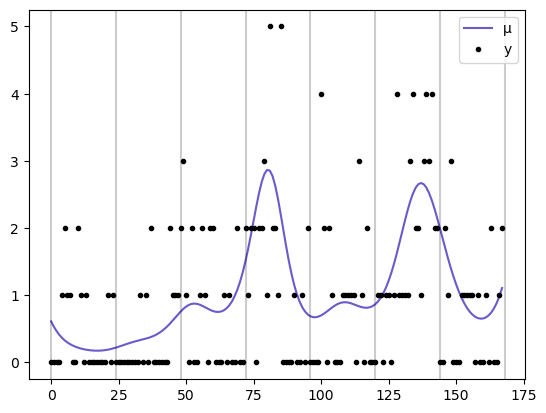

In [342]:
plt.plot(x, mu.eval(), color="slateblue", label="μ")
plt.plot(x, y, ".k", label="y");
for i in range(8):
    plt.axvline(x=i*24, color="k", alpha=0.2) # light gray line to indicate different days
plt.legend(loc='upper right');

This data isn't real hospital nurse call data of course.  Does it resemble what you might expect?  If not, feel free to tweak the `ell` and `eta` parameters. If you do, make sure to bring your changes down to the models below because we are assuming we know those values in the model.  Notice that as the rate $\mu$ (in blue) changes over time, the observed counts tend to cluster around it.  Remember we can never observe the blue curve, only the black dots.

Next, let's try and fit the data $y$ to see if we can recover the changing and unknown rate $\mu$.  We of course don't observe the rate directly, just the counts $y$.  The PyMC code for this model is below:

In [343]:
with pm.Model() as model:
    eta = 1.0
    ell = 12.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None])
    
    f = pm.MvNormal("f", mu=np.zeros(N), cov=K)
    mu = pm.Deterministic("mu", pm.math.exp(f))
    
    y_ = pm.Poisson("y", mu=mu, observed=y)

In [344]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'f': array([-0.30935319,  0.39163726, -0.46227963, -0.91972824,  0.82069784,
       -0.9995913 ,  0.91575124,  0.23645033,  0.40028468, -0.29585778,
        0.42538165, -0.64453839, -0.44623441,  0.20363682,  0.73177692,
        0.5311491 , -0.70214699,  0.21263721, -0.2703753 ,  0.35181062,
        0.31125185,  0.28837958,  0.14398884, -0.36398316, -0.23090393,
        0.55969697, -0.7329529 ,  0.99047527, -0.73419178, -0.14627379,
        0.52690891, -0.05329698,  0.78454405,  0.76523362, -0.24782833,
       -0.74078513, -0.67615011,  0.0842857 , -0.99948055, -0.93013745,
        0.81795441, -0.91645229,  0.77331936, -0.52521417,  0.23561755,
        0.43689888,  0.82647032,  0.93742828,  0.34251339, -0.48096772,
        0.02206011,  0.98807482, -0.80745435,  0.72658773,  0.88542884,
       -0.14755169,  0.92661856,  0.03560671,  0.47333068, -0.89291378,
       -0.54181398, -0.53153302, -0.30593779, -0.32817477,  0.19186154,
        0.62701934, -0.35967389, -0.69960937, -0.14474667, -0.88475375,
        0.12850937, -0.6068335 , -0.31927098, -0.45689083,  0.02634488,
       -0.92730263,  0.20935861, -0.25982517,  0.4542727 , -0.21732991,
       -0.70474268,  0.06197412,  0.55347456,  0.0553204 , -0.8163896 ,
       -0.16089967,  0.86159881,  0.29051696,  0.5913761 ,  0.07967413,
       -0.79955636,  0.59492994, -0.30598244,  0.87311583,  0.97786694,
       -0.2945364 , -0.66556276,  0.54097608, -0.59659985, -0.46578746,
       -0.02208457,  0.89408305,  0.93235307, -0.8251255 , -0.21571226,
       -0.38025121,  0.56527021, -0.70122529,  0.5106818 ,  0.01849364,
        0.43269397, -0.90957877, -0.63428389,  0.33401765,  0.11488903,
       -0.3700048 , -0.15744597,  0.44565812,  0.24036153, -0.1404062 ,
        0.87336967, -0.04371367,  0.8450685 , -0.87899761, -0.00552319,
        0.56719134,  0.48121885, -0.86134163,  0.16604436,  0.40238626,
        0.96600084,  0.64929814,  0.13031463, -0.92359694, -0.39632497,
       -0.28575447, -0.17695498, -0.52178745, -0.8267479 ,  0.15927285,
        0.82519596, -0.66202526, -0.58540183,  0.55663868,  0.74897776,
       -0.91216453,  0.81676627, -0.70915475, -0.82699915, -0.82489789,
        0.81159093, -0.74869725,  0.40299883, -0.25480015, -0.23360041,
        0.58339518, -0.50075731,  0.94885685,  0.37908514,  0.2980415 ,
       -0.18515656,  0.41513223, -0.24892319,  0.70839145,  0.42851425,
        0.66616644, -0.95969275,  0.83304162])}

Logp initial evaluation results:
{'f': -inf, 'y': -267.93}
You can call `model.debug()` for more details.

### Aside

You may have noticed that we observed $N=168$ data points, and our model has $N=168$ unknowns!  It's common in Bayesian models (and particularly GP models) to have more unknown parameters than data points.  There is no problem with doing this.  Intuitively the reason it's OK is because we are also including in the model _very_ strong prior information.  The 168 unknown parameters that make up the GP aren't free to do whatever they wish.  They are strongly constrained by the GP prior.  The kernel we're using enforces this.  This means that the _effective_ degrees of freedom for this model is much less than $N=168$ and we can fit things just fine. 

# Sec 40: The first trick and the Cholesky decomposition

Not a good start.  MCMC failed because the `f` vector proposed by the sampler was deemed impossible by the model (it gave it a log probability of `-inf`).  Remember the two tricks?  Now we're starting to need them.  In order to understand them though, we need to know something about the Cholesky decomposition so we'll introduce it at a high level here.  You don't need to know exactly how to do the Cholesky decomposition to understanding GPs, but it's very useful to know what it is and how to make it work.

The Cholesky decomposition is a matrix square root.  What two numbers multiply to equal 9?  The Cholesky decomposition gives you the answer to the same question, but for matrices instead of scalars.  What two matrices multiplied together, equal your covariance matrix?  Let's try it out.  Let's use our covariance matrix from above, `K`.  Let's take it's square root (Cholesky decomposition) and verify that it actually is the matrix square root.

In [1]:
K = K.eval() # convert from pytensor to numpy
plt.imshow(K, interpolation='none'); plt.colorbar();

NameError: name 'K' is not defined

The Cholesky decomposition is available in Numpy, Scipy, Pytensor, and many other matrix libraries.  It's a common convention you'll see to name the Cholesky factor (as it's called) `L`.

In [333]:
L = np.linalg.cholesky(K)

LinAlgError: Matrix is not positive definite

It failed.  It says the matrix is not positive definite.  In addition to being symmetric, positive definiteness is a mathematical criteria that all covariance matrices must fulfill.  The problem is actually numerical.  The reason is because the Cholesky decomposition is very sensitive to floating point errors.  If one or more of the eigenvalues of a covariance matrix is zero, then the matrix isn't positive definite.  This matrix probably has one or more _tiny_ eigenvalues, but `ExpQuad` is solid, it **always** produces positive definite covariance matrices (it is a covariance *function* after all) so we _know_ they're all not zero, they just look zero to the computer because it doesn't represent decimals with infinite precision.

If that doesn't make sense to you, that's completely OK.  The solution is easy.  The first trick is to not worry about it add a very tiny diagonal to the covariance matrix, like this:

In [334]:
K_fixed = K + 1e-6 * np.eye(K.shape[0])

Let's make the same image and see if we can see what we did:

In [2]:
plt.imshow(K, interpolation='none'); plt.colorbar();

NameError: name 'plt' is not defined

We definitely cannot.  We added 0.000001 to each of the diagonal elements.  The max of this array is now 1.000001 instead of 1.  It hardly changes anything, except for this:

In [337]:
L = np.linalg.cholesky(K_fixed)

Now there are no errors and the Cholesky decomposition runs without issue.  Not all covariance matrices need this correction, but it doesn't hurt anything so people usually just add a bit to the diagonal all the time by default.  Feel free to take that approach.  That's what PyMC and many other GP libraries do.  In PyMC if you happen to need a tiny bit more or less, there is a `jitter` kwarg for the relevant GP methods where you can set this.  The default value is 1e-6.  There's no need to worry about eigenvalues or numerical precision most of the time, especially if you've scaled your data to reasonable ranges.  Just add a tiny bit to the diagonal and move on.

Now, let's take a look at `L`, and verify that if we "square" `L` we get back `K`.

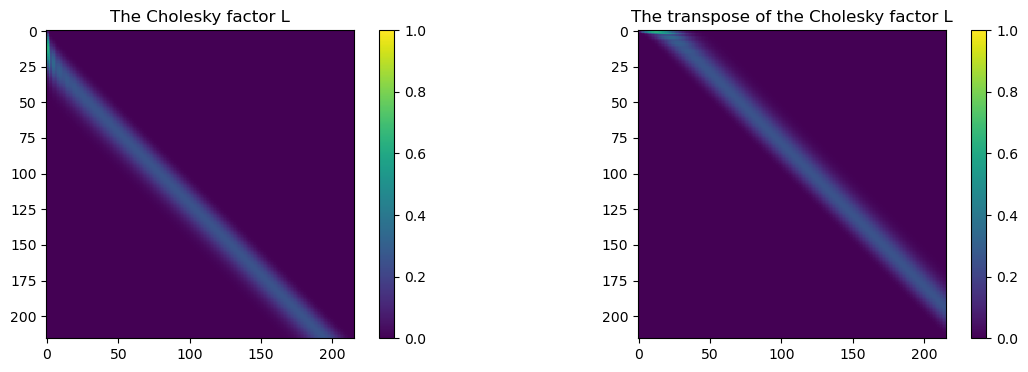

In [338]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten()

m = axs[0].imshow(L, interpolation='none'); plt.colorbar(m, ax=axs[0]);
m = axs[1].imshow(np.transpose(L), interpolation='none'); plt.colorbar(m, ax=axs[1]);

axs[0].set_title("The Cholesky factor L");
axs[1].set_title("The transpose of the Cholesky factor L");

It's a bit hard to see, but every element above the diagonal of `L` is equal to _exactly_ zero.  We say that the matrix `L` is "lower triangular".  We also plot the _transpose_ of `L`, denoted $L^T$.  The transpose swaps rows and columns.  $L^T$ is upper triangular.  Next we plot the original matrix $K$ next to $LL^T$ to verify that they are the same.

In Python, `L @ L.T` is the same as `np.dot(L, L.T)`.  The `@` symbol is the dot product.

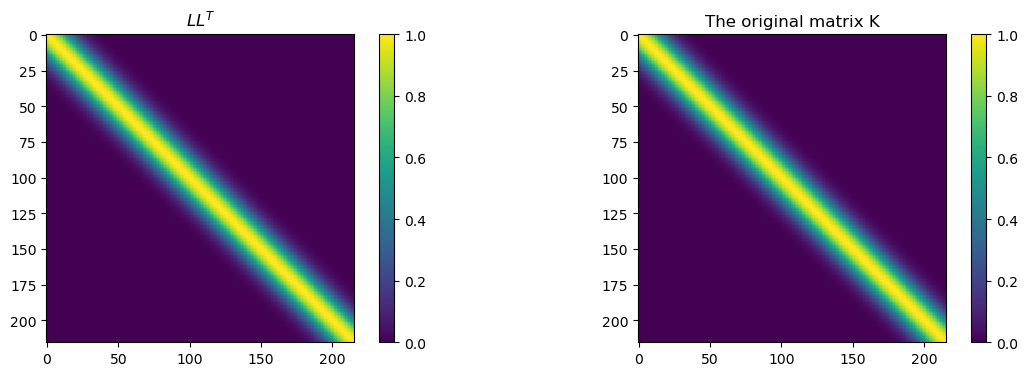

In [339]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten()

m = axs[0].imshow(L @ L.T, interpolation='none'); plt.colorbar(m, ax=axs[0]);
m = axs[1].imshow(K, interpolation='none'); plt.colorbar(m, ax=axs[1]);

axs[0].set_title("$LL^T$");
axs[1].set_title("The original matrix K");

We can see that they're the same.  There are certainly more precise ways than just looking to verify that the elements are the same (or at least close enough!), so feel free to try those out on your own.  Let's rerun our model, but this time include trick number 1.

In [310]:
with pm.Model() as model:
    eta = 1.0
    ell = 12.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None]) + 1e-6 * pt.eye(N)
    
    f = pm.MvNormal("f", mu=np.zeros(N), cov=K)
    mu = pm.Deterministic("mu", pm.math.exp(f))
    
    y_ = pm.Poisson("y", mu=mu, observed=y)

Now you can hum the Jeopardy theme to yourself (over and over) and start sampling.

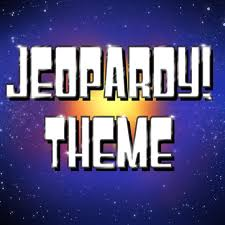

In [311]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 504 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


This time it ran!  But unfortunately it was quite slow and it gave lots of warnings about bad samples.  Large rhat, low effective sample sizes, maximum tree depth on every chain.  That's nearly all the warnings you can get!  No divergences though, somehow.  The way to fix this isn't to dig into all these one by one.  Instead we'll cut to the chase and fix them by introducing trick number two. 

# Sec 50: The second trick, the non-centered parameterization

This trick depends on the Cholesky factorization too.  Did you know that when PyMC draws a random sample from a multivariate normal, it takes the Cholesky decomposition of the covariance matrix internally?  Let's draw a sample from a multivariate normal, but this time do so using the Cholesky decomposition.  Let's repeat our data generating procedure

In [220]:
eta = 1.0
ell = 12.0

# equally spaced x points
N = 24 * 7 # (one week, hourly data)
x = np.arange(N)

# define covariance function, then evaluate it over the 100 x locations
cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
K = cov_func(x[:, None], x[:, None]).eval()

# define the GP prior
gp_prior = pm.MvNormal.dist(mu=np.zeros(N), cov=K)

# draw a sample from the GP prior using the Cholesky decomposition
L = np.linalg.cholesky(K + 1e-6 * np.eye(N)) # notice the use of the first trick
v_draw = pm.draw(pm.Normal.dist(mu=0.0, sigma=1.0, size=N), draws=1) # draw N standard normal random samples
gp_draw = L @ v_draw # "rotate" them using the Cholesky factor L

# define the poisson likelihood and draw our dataset from it, look at the shapes below and you'll see that its vectorized
mu = pm.math.exp(gp_draw)
likelihood = pm.Poisson.dist(mu=pm.math.exp(gp_draw))
y = pm.draw(likelihood, draws=1)

In [345]:
x.shape, K.shape, gp_draw.shape, y.shape

((168,),
 TensorConstant(TensorType(int64, shape=(2,)), data=array([168, 168])),
 (168,),
 (168,))

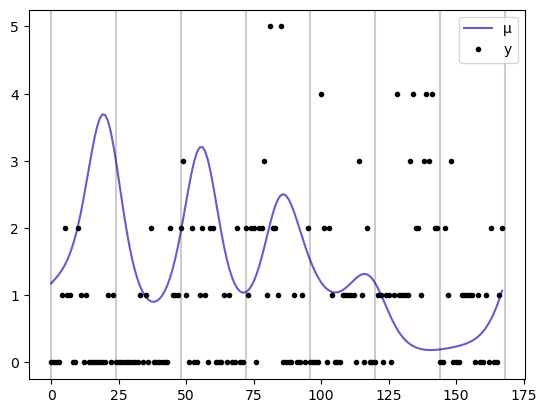

In [346]:
plt.plot(x, mu.eval(), color="slateblue", label="μ")
plt.plot(x, y, ".k", label="y");
for i in range(8):
    plt.axvline(x=i*24, color="k", alpha=0.2) # light gray line to indicate different days
plt.legend(loc='upper right');

We don't get the exact same data set as before, but that's alright.  We're clearly getting the same sort of samples from a multivariate normal random variable.  This is actually how most numerical routines draw multivariate normal samples.  They first draw N samples from a standard normal (mean zero, standard deviation 1) and then "rotate" them (as they say) using the Cholesky factor.  This is because nice numerical routines already exist to both calculate the Cholesky factor and draw standard normal random variates.  

This is completely analogous to the non-centered parameterization for univariate normals.  Here's one way to draw a normal,
$$
x \sim N(0, \sigma^2) \,.
$$
Here's another equivalent way:  We can draw a standard normal first, and then multiply it by the standard deviation,
$$
\begin{align}
v &\sim N(0, 1) \\
x &= \sigma \cdot v \,.
\end{align}
$$
Make an analogy between the variance $\sigma^2$ and the covariance $K$.  Then also between the standard deviation $\sigma$ (the square root of the variance) and the Cholesky factor $L$ (the matrix square root of $K$).  

#### Explaination 1

(Not sure how much to talk about non-centering? or basically assume this is known already.  Or just link to something else.)

When doing MCMC sampling, you can either evaluate $N(0, \sigma^2)$ given some $x$, or evaluate $N(0, 1)$ given some $v$, then transform $v$ into $x$.  Mathematically they are equal -- they are different parameterizations.  This is the second trick -- using the non-centered parameterization for multivariate normals.  Reparameterization and MCMC is another important topic generally, but for this course it's enough to know that you should always (with probability 0.99999) use the non-centered parameterization when working with GPs.  Like adding a small diagonal to the covariance matrix, most GP libraries do this silently under the hood too. 

#### Explaination 2 (wording, combine 1 and 2 or pick one)
Why this reparameterization works so well is an interesting topic and is relevant to lots of other parts of applied Bayesian modeling.  It suffices to know that, when you have a GP (or any multivariate normal) term in your model, this parameterization is *nearly always* better.  Start with it.  If you're interested in knowing more, take a look link link and link and this topic is covered in the Advanced Regression course.  The short answer for why it works better is because now the sampler is working with $v$ instead of $f$ directly, and the posterior of $v$ is more _spherical_ than the posterior of $f$, which usually has a complicated geometry.  

Next, let's implement the non-centered parameterization and we'll see a big difference in sampling efficiency.

In [347]:
with pm.Model() as model:
    eta = 1.0
    ell = 12.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None])
    
    L = pt.slinalg.cholesky(K + 1e-6 * pt.eye(N)) # still doing the first trick
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=N)
    f = pm.Deterministic("f", L @ v)
    
    mu = pm.Deterministic("mu", pm.math.exp(f))
    
    y_ = pm.Poisson("y", mu=mu, observed=y)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


It sampled **way** faster, and all the warnings are gone.  

Here's what the fit looks like.  It does a really nice job of representing the data.

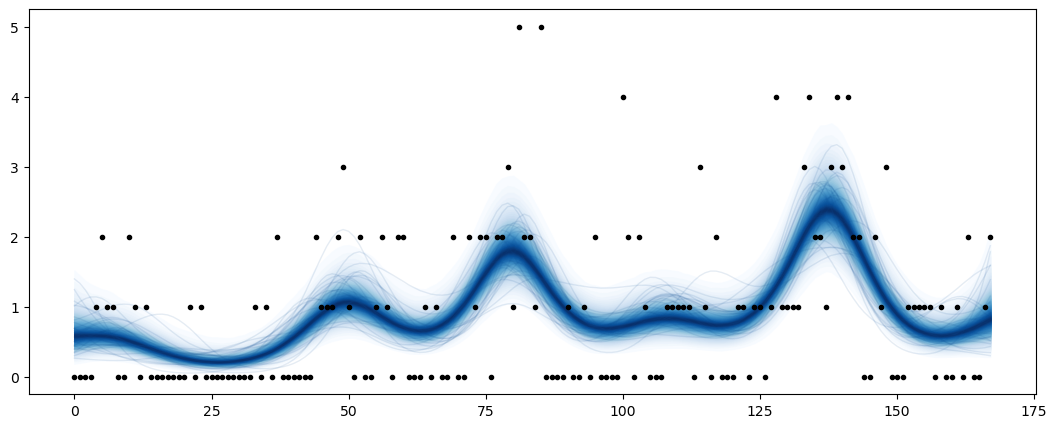

In [329]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

s = az.extract(idata, group="posterior", var_names="mu").data.T
pm.gp.util.plot_gp_dist(ax, s, x, palette="Blues")

plt.plot(x, y, ".k");

# Sec 60: From multivariate normals to Gaussian processes

**Heads up, this section is the most important one!**  So you may have noticed that there's no code in our model that says "GP".  Instead it looks like we're modeling `f` as just a multivariate normal with dimension `N = 168`.  It's time to bring out the dictionary (really [Wikipedia](https://en.wikipedia.org/wiki/Gaussian_process)) definition of a Gaussian process:

> A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution.

Especially pay attention to the part where it says **"such that every finite collection of those random variables has a multivariate normal distribution"**.  That's what we have here.  We had 168 hours worth of data (which is a collection that is in fact finite, $168 \lt \infty$) -- but we could make a forecast into the future for 8 more hours, or even 8 more days.  We could even try to forecast forward 8000 more years if we wanted to.  Could we forecast *infinity* more years?  Sure, if we had a infinitely big computer.  Mathematically there is no reason why not.  

We only observed a **finite** collection of data points though, $N=168$ to be exact.  So we fit our GP as a **finite collection of random variables** with a multivariate normal.  We're just choosing to locate our $N=168$ multivariate normal at the same locations as the data points -- because that's where we have data. 

A GP isn't the same thing as a multivariate normal though.  Let's try something out to see why.  Let's fit a larger finite collection of locations now, $N = 168 + 48$, our original $x$-locations plus 48 more hours into the future.  We don't have data here though of course, but that's OK!  If you look carefully at the code, the only inputs to the GP are the $x$-locations.  The $y$-values have nothing to do with the GP.  That means we can build our GP over any $x$-locations we need, and just feed the corresponding part into the likelihood to match up to the $y$-values.  It'll be clearer when you look at the new model code below.

To reiterate, this model is the same as before, except now our finite collection of random variables (the GP) has grown by two days from 168 to 216.  Of course it's still a multivariate normal.  But we can't just "grow" a multivariate normal on it's own because multivariate normals have a fixed dimension.  We need both the concepts of a Gaussian process and a covariance function to be able to expand the multivariate normal to any $x$-locations we like.  

So we've increased our finite collection of random variables from 168 to 216, but we still have observed only the original 168 data points.  All we need to do is select the first 168 points of our GP to plug into the likelihood where we have that data.  The last 48 points we can call our "predictions" or "forecast" -- the scare quotes are there because these points are just in there with the same GP.  There's nothing special or different about them, other than the fact that we don't have observed data at their x locations.  The GP doesn't really care where you've actually observed data though.  Remember sampling from the prior?  Again, we only gave $x$-locations. 

In [330]:
new_x = np.arange(168 + 48)
new_N = len(new_x)

with pm.Model() as model:
    eta = 1.0
    ell = 12.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(new_x[:, None])  # we replaced x with new_x here
    
    L = pt.slinalg.cholesky(K + 1e-6 * pt.eye(new_N))  # now size is new_N
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=new_N)  # same here
    f = pm.Deterministic("f", L @ v)
    
    mu = pm.Deterministic("mu", pm.math.exp(f))
    
    y_ = pm.Poisson("y", mu=mu[:N], observed=y)  # select mu down to its original length of 168.  The last 48 points are our "forecast"

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


Now let's plot all 216 points of `mu` with the data.  We'll add a vertical line to separate the regions into "fit" and "forecast".

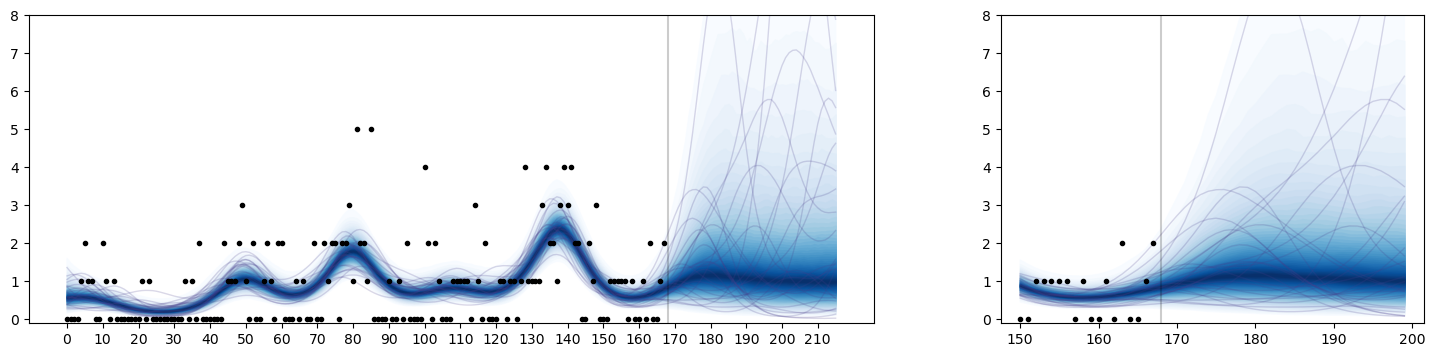

In [331]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 4))
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

s = az.extract(idata, group="posterior", var_names="mu").data.T
pm.gp.util.plot_gp_dist(axs[0], s, new_x, palette="Blues", plot_samples=False)
s_ix = np.arange(25) # plot the same set of samples in both panels
axs[0].plot(new_x, s[s_ix, :].T, color="darkslateblue", alpha=0.2, linewidth=1)

axs[0].axvline(x=168, color="k", alpha=0.2)
axs[0].plot(x, y, ".k");
axs[0].set_xticks(np.arange(0, new_N, 10));
axs[0].set_ylim([-0.1, 8])

ix = slice(150, 200)
pm.gp.util.plot_gp_dist(axs[1], s[:, ix], new_x[ix], palette="Blues", plot_samples=False)
axs[1].plot(new_x[ix], s[s_ix, ix].T, color="darkslateblue", alpha=0.2, linewidth=1)

axs[1].axvline(x=168, color="k", alpha=0.2)
axs[1].plot(x[ix], y[ix], ".k");
axs[1].set_xticks(np.arange(150, 201, 10));
axs[1].set_ylim([-0.1, 8]);

The results show a nice continuity from the fitted data locations to the "forecast", or the $x$-values that are out past where the data was located.  Note again that we could have chosen $x$-locations anywhere, like before or between the observed data.

Let's return again to the Wikipedia definition to make sure we understand it.

> A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution.

So we just made a new finite collection of random variables that has also has a multivariate normal distribution.  And we saw how we can continuously extend it to an arbitrary number of new locations thanks to our covariance function.  

GPs are infinite dimensional objects in the sense that they're defined over their whole domain $x$, so an infinite number of locations.  When we made our first model, we created a view of only 168 of those dimensions.  We then broadened our view to 48 more data points, so that's 216 out of infinity possible dimensions.  Now, imagine holding an object up with some complicated shape up under the sun, like a rubber duck, and then looking at it's shadow.  As you rotate it around it's shadow doesn't always look like what it is.  This is essentially what we're doing here.  Except instead of having a 3D object and looking at its 2D shadow to try and understand it, we're holding up an infinite dimensional GP and looking at it's $N$D shadow (projected again onto your 2D computer screen!).

## Conclusion

This is probably the most important section of this course.  Please rewatch if things feel fuzzy.  You should now know _what_ a GP is and the basics of how to fit one to to data.  When people say, "a GP is a prior over functions", or "a GP is infinite dimensional", you should now know exactly what that means.  

Although we understand **what** they are, we're not ready to end the GP course yet and send you on your way.  There are a few more concepts we need to round out the basics:

- Setting priors on the scale and lengthscale ($\eta$ and $\ell$).  We assumed we already knew these quantities, and they play a very important role in these types of models.
- Conditioning (for making predictions *without* refitting).  You may have noticed that fitting and forecasting happened at the same time.  In practice this is very unwieldy.  
- Marginalization (for when the likelihood is Gaussian).

These ideas form the core for understanding GPs.  After this core, later advanced lessons will broaden your knowledge and build your toolbox.  We'll get better at using different GP approximations (to try to get better than $\mathcal{O}(n^3)$) so we can work with larger datasets.  We'll also introduce different kernel functions and even teach you how to build your own.  There are *many* other (and better) options beyond `ExpQuad`.  We'll also practice on a few different real world datasets so you can hone your modeling skills and know when it's a good idea to apply GPs in your work.  Finally, there are many mathematical connections between GPs and other types of models, like linear regression, support vector machines and neural networks.  Understanding these connections teaches you about both GPs and their related models.  We'll describe these connections at a high level and point you towards resources to really dig in if you're interested.      

In the next lesson, we'll learn about setting priors on covariance/kernel function hyperparameters like $\eta$ and $\ell$.  At the same time we'll introduce the Matern family of kernels -- what you'll probably use nearly all the time (and have actually already started using).  Finally we'll quickly overview other classes of kernel functions and basic operations on them.  



# Exercises

- draw from prior with unordered x data.  x = np.random.rand or something.  Arg sort it to fix it.  Show that ordering of x doesnt matter.  plot covariance matrix ordered and unordered
- ...